In [3]:
import pandas as pd
import numpy as np
import string
import re
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import janitor 
import geopandas as gpd

In [ ]:
# for csvs
#data_2020 = pd.read_csv("311_data/311_2020.csv")
#data_2021 = pd.read_csv("311_data/311_2021.csv")
#data_2022 = pd.read_csv("311_data/311_2022.csv")
#data_2023 = pd.read_csv("311_data/311_2023.csv")
#data_2024 = pd.read_csv("311_data/311_2024.csv")

In [ ]:
# for shapefiles
data_2020 = gpd.read_file("311_data/311_2020_shapes/311_2020.shp")
data_2021 = gpd.read_file("311_data/311_2021_shapes/311_2021.shp")
data_2022 = gpd.read_file("311_data/311_2022_shapes/311_2022.shp")
data_2023 = gpd.read_file("311_data/311_2023_shapes/311_2023.shp")
data_2024 = gpd.read_file("311_data/311_2024_shapes/311_2024.shp")


In [ ]:
datasets = [data_2020 , data_2021, data_2022, data_2023, data_2024]
for data in datasets:
    data = data.clean_names()

In [ ]:
# # Code copied from Ray's Feasability
# Create a dictionary to store all the data
data_dict = {
    2020: data_2020,
    2021: data_2021,
    2022: data_2022,
    2023: data_2023,
    2024: data_2024
}

for year, df in data_dict.items():
    print(f"data_{year}: {df.shape}")

# Check the consistency of the columns
for year, df in data_dict.items():
    print(f"{year}: {df.columns}")

### Standardize the column names

In [ ]:
# Rename some columns in data_2020
data_2020_clean = data_2020.drop(["service__1", "service__2", "FID", "public_url", "specify_th"], axis=1)
data_2020_clean.rename(columns={"X": "x",
                          "Y": "y",
                          "service_re": "service_request_id",
                          "sap_notifi": "sap_notification_number",
                          "case_age_d": "case_age_days",
                          "case_recor": "case_record_type",
                          "service_na": "service_name",
                          "street_add": "street_address",
                          "council_di": "council_district",
                          "comm_plan_": "comm_plan_code",
                          "comm_plan1": "comm_plan_name",
                          "case_origi": "case_origin",
                          "public_des": "public_description",
                          "date_reque": "date_requested",
                          "date_close": "date_closed",

                          }, inplace=True)





In [ ]:
# Only select the new 2020 columns from the other years
#print(data_2020_clean.columns)

data_2021_clean = data_2021.reindex(columns = data_2020_clean.columns)
#print(data_2021_clean.columns)
data_2022_clean = data_2022.reindex(columns = data_2020_clean.columns)
data_2023_clean = data_2023.reindex(columns = data_2020_clean.columns)
data_2024_clean = data_2024.reindex(columns = data_2020_clean.columns)

Concatenate the 311 datasets by row (stacked on top of each other)

In [ ]:
data_concat = pd.concat([data_2020_clean, data_2021_clean, data_2022_clean, data_2023_clean, data_2024_clean])

In [ ]:
data_concat.head()

Create an variable on the proportion of letters that are all caps (besides the start of a sentence)

In [ ]:
def remove_sentence_starts(text):
    if pd.isna(text):
        return ""
    return re.sub(r'(^[A-Z])|(?<=[.!?]\s)[A-Z]', '', text)

no_sentence_starts = data_concat["public_description"].apply(remove_sentence_starts)
data_concat["prop_uppercase"] = (no_sentence_starts.str.count(r"[A-Z]"))/(no_sentence_starts.str.len())

In [ ]:
data_concat["prop_uppercase"]

In [ ]:
data_concat[["public_description","prop_uppercase"]]

In [ ]:
# From Ray's Feasability
def clean_text(df, col_name):
    return (
        df[col_name]
        .fillna("")     #Replaces all missing values with an empty string ""
        .str.lower()    #Converts all text to lowercase
        .str.replace(f"[{string.punctuation}]", "", regex=True) #Removes all punctuation marks from the text
        .str.replace(r"\s+", " ", regex=True) #Replaces multiple spaces or whitespace characters
        .str.strip()    #Removes leading and trailing spaces from each text string
    )

data_concat["clean_text"] = clean_text(data_concat, "public_description")
data_concat["word_count"] = data_concat["clean_text"].str.split().str.len()

In [ ]:
data_concat.head()
len(data_concat)

In [14]:
# reproject to California Zone 6
data_concat = data_concat.to_crs(epsg=2230)

In [ ]:
# save to csv
#data_concat.to_csv("all_years_311.csv", index=False)

In [19]:
# save to shp
data_concat.to_file("modified_data/all_years_311.shp")

/Users/gabriellelow/anaconda3/envs/css/lib/python3.13/site-packages/pyogrio/raw.py:723: RuntimeWarning: Field date_reque create as date field, though DateTime requested.
  ogr_write(
/Users/gabriellelow/anaconda3/envs/css/lib/python3.13/site-packages/pyogrio/raw.py:723: RuntimeWarning: Field date_close create as date field, though DateTime requested.
  ogr_write(


### Preparing data to join with other variables

In [ ]:
#data_concat = gpd.read_file("modified_data/all_years_311.shp")

Spatial join with Land Use

In [4]:
land_use = gpd.read_file("other_data/Land_Use_2024_shapefile/Land_Use_2024.shp")

In [5]:
land_use.head()

lu                DESCRIPTIO    Shape_Leng    Shape_Area  \
0  1000  Spaced Rural Residential   1870.505325  1.996575e+05   
1  1000  Spaced Rural Residential  13832.316321  1.785618e+06   
2  1000  Spaced Rural Residential   3976.166582  6.769741e+05   
3  1000  Spaced Rural Residential   4102.026813  3.419031e+05   
4  1000  Spaced Rural Residential    892.139662  4.798404e+04   

                                            geometry  
0  POLYGON ((6255211.907 1968923.648, 6255145.479...  
1  POLYGON ((6263645.217 1970229.288, 6263610.985...  
2  POLYGON ((6263874.387 1972038.938, 6263875.65 ...  
3  POLYGON ((6265785.134 1972597.327, 6265787.982...  
4  POLYGON ((6247057 1980319, 6247009.999 1980242...

In [6]:
print(land_use.DESCRIPTIO.unique())
len(land_use.DESCRIPTIO.unique())

['Spaced Rural Residential' 'Spaced Rural Residential Without Units'
 'Single Family Detached' 'Single Family Multiple-Units'
 'Single Family Residential Without Units' 'Multi-Family Residential'
 "Single Room Occupancy Units (SRO's)"
 'Multi-Family Residential Without Units' 'Mobile Home Park' 'Jail/Prison'
 'Dormitory' 'Military Barracks' 'Monastery'
 'Other Group Quarters Facility' 'Hotel/Motel (Low-Rise)'
 'Hotel/Motel (High-Rise)' 'Resort' 'Heavy Industry' 'Industrial Park'
 'Light Industry - General' 'Warehousing' 'Public Storage'
 'Extractive Industry' 'Junkyard/Dump/Landfill' 'Commercial Airport'
 'Military Airport' 'General Aviation Airport' 'Airstrip'
 'Rail Station/Transit Center' 'Freeway' 'Communications and Utilities'
 'Parking Lot - Surface' 'Parking Lot - Structure' 'Park and Ride Lot'
 'Railroad Right of Way' 'Road Right of Way' 'Other Transportation'
 'Marine Terminal' 'Wholesale Trade' 'Regional Shopping Center'
 'Community Shopping Center' 'Neighborhood Shopping Cen

104

<Axes: >

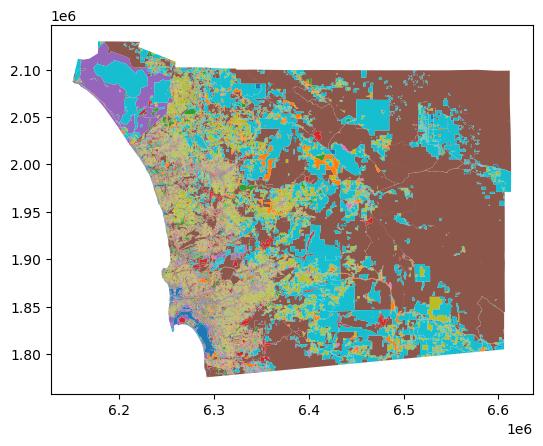

In [7]:
land_use.plot(column="DESCRIPTIO")


Condense into fewer categories: 
- Residential
- Institutional/Group Quarters
- Industrial
- Commercial
- Transportation/Utilities
- Recreation/Open Space
- Agricultural
- Water/Natural Features
- Vacant/Under Construction

In [8]:


land_use['land_use_binned'] = land_use['DESCRIPTIO'].case_when(
    [
        # Residential
       (land_use['DESCRIPTIO'].isin([
            'Spaced Rural Residential', 'Spaced Rural Residential Without Units',
            'Single Family Detached', 'Single Family Multiple-Units',
            'Single Family Residential Without Units', 'Multi-Family Residential',
            'Multi-Family Residential Without Units', 'Mobile Home Park',
            "Single Room Occupancy Units (SRO's)"
        ]), "Residential"),

        # Institutional / Group Quarters
        (land_use['DESCRIPTIO'].isin([
            'Jail/Prison', 'Dormitory', 'Military Barracks', 'Monastery',
            'Other Group Quarters Facility', 'UCSD/VA Hospital/Balboa Hospital',
            'Hospital - General', 'Other Health Care', 'Military Use',
            'Military Training', 'Weapons Facility', 'SDSU/CSU San Marcos/UCSD',
            'Other University or College', 'Junior College', 'Senior High School',
            'Junior High School or Middle School', 'Elementary School',
            'School District Office', 'Other School', 'Library', 'Post Office',
            'Mission', 'Religious Facility', 'Other Public Services', 'Fire/Police Station'
        ]), "Institutional"),

        # Industrial
        (land_use['DESCRIPTIO'].isin([
            'Heavy Industry', 'Industrial Park', 'Light Industry - General',
            'Warehousing', 'Public Storage', 'Extractive Industry',
            'Junkyard/Dump/Landfill'
        ]), "Industrial"),

        # Commercial
        (land_use['DESCRIPTIO'].isin([
            'Wholesale Trade', 'Regional Shopping Center', 'Community Shopping Center',
            'Neighborhood Shopping Center', 'Specialty Commercial',
            'Automobile Dealership', 'Arterial Commercial', 'Service Station',
            'Other Retail Trade and Strip Commercial', 'Office (High-Rise)',
            'Office (Low-Rise)', 'Government Office/Civic Center','Hotel/Motel (High-Rise)', 'Hotel/Motel (Low-Rise)', 'Resort',
            'Cemetery'
        ]), "Commercial"),

        # Mixed use
        (land_use['DESCRIPTIO'].isin(["Mixed Use"]), "Mixed Use"),

        # Transportation / Utilities
        (land_use['DESCRIPTIO'].isin([
            'Commercial Airport', 'Military Airport', 'General Aviation Airport',
            'Airstrip', 'Rail Station/Transit Center', 'Freeway', 'Road Right of Way',
            'Railroad Right of Way', 'Park and Ride Lot', 'Parking Lot - Surface',
            'Parking Lot - Structure', 'Other Transportation',
            'Communications and Utilities', 'Marine Terminal'
        ]), "Transportation"),

        # Recreation / Open Space
        (land_use['DESCRIPTIO'].isin([
            'Tourist Attraction', 'Stadium/Arena', 'Racetrack', 'Golf Course',
            'Golf Course Clubhouse', 'Convention Center', 'Marina',
            'Olympic Training Center', 'Casino', 'Other Recreation - High',
            'Other Recreation - Low', 'Park - Active', 'Open Space Park or Preserve',
            'Beach - Active', 'Beach - Passive', 'Landscape Open Space',
            'Residential Recreation', 'Undevelopable Natural Area'
        ]), "Rec / Open Space"),

        #  Agricultural
        (land_use['DESCRIPTIO'].isin([
            'Orchard or Vineyard', 'Intensive Agriculture', 'Field Crops'
        ]), "Agricultural"),

        #  Water / Natural
        (land_use['DESCRIPTIO'].isin([
            'Water', 'Bay or Lagoon', 'Lake/Reservoir/Large Pond'
        ]), "Water"),


        #  Vacant 
        (land_use['DESCRIPTIO'].isin([
            'Vacant and Undeveloped Land','Residential Under Construction', 'School Under Construction',
            'Industrial Under Construction', 'Office Under Construction', 'Commercial Under Construction',
            'Freeway Under Construction', 'Road Under Construction'
        ]), "Vacant / Under Construction")
    ]
    
)


In [9]:
land_use.head()

lu                DESCRIPTIO    Shape_Leng    Shape_Area  \
0  1000  Spaced Rural Residential   1870.505325  1.996575e+05   
1  1000  Spaced Rural Residential  13832.316321  1.785618e+06   
2  1000  Spaced Rural Residential   3976.166582  6.769741e+05   
3  1000  Spaced Rural Residential   4102.026813  3.419031e+05   
4  1000  Spaced Rural Residential    892.139662  4.798404e+04   

                                            geometry land_use_binned  
0  POLYGON ((6255211.907 1968923.648, 6255145.479...     Residential  
1  POLYGON ((6263645.217 1970229.288, 6263610.985...     Residential  
2  POLYGON ((6263874.387 1972038.938, 6263875.65 ...     Residential  
3  POLYGON ((6265785.134 1972597.327, 6265787.982...     Residential  
4  POLYGON ((6247057 1980319, 6247009.999 1980242...     Residential

In [11]:
land_use.crs

<Projected CRS: EPSG:2230>
Name: NAD83 / California zone 6 (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - California - counties Imperial; Orange; Riverside; San Diego.
- bounds: (-118.15, 32.53, -114.42, 34.08)
Coordinate Operation:
- name: SPCS83 California zone 6 (US survey foot)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

Join with 311 data

In [17]:
land_use_311 = gpd.sjoin(data_concat, land_use, how="left", predicate="within")

In [18]:
land_use_311.head()

service_re sap_notifi date_reque  case_age_d             case_recor  \
0   2856645.0       None 2020-01-19         2.0  Neighborhood Policing   
1   2856658.0       None 2020-01-19         2.0  Neighborhood Policing   
2   2856660.0       None 2020-01-19         2.0  Neighborhood Policing   
3   2856674.0       None 2020-01-19         0.0  Neighborhood Policing   
4   2856676.0       None 2020-01-19         5.0   ESD Complaint/Report   

   service_na date_close  status        lat         lng  ... prop_upper  \
0  Encampment 2020-01-21  Closed  32.690739 -117.094065  ...        0.0   
1  Encampment 2020-01-21  Closed  32.739258 -117.158897  ...        0.0   
2  Encampment 2020-01-21  Closed  32.755149 -117.085003  ...        0.0   
3  Encampment 2020-01-19  Closed  32.739992 -117.244911  ...        0.0   
4  Encampment 2020-01-24  Closed  32.749275 -117.161033  ...        0.0   

                                          clean_text  word_count  \
0                                         trash left           2   
1  homeless people smoking crack next to playgrou...          16   
2  people outside back gate confrontational smoki...          16   
3  homeless person in front yard of recently sold...           9   
4  this alley has become a regular living area fo...          43   

                          geometry index_right      lu  \
0  POINT (6301971.982 1832154.545)     83663.0  4112.0   
1  POINT (6282179.562 1849974.834)    100249.0  7601.0   
2  POINT (6304947.819 1855566.593)     76065.0  1200.0   
3    POINT (6255733.327 1850483.5)     24482.0  1110.0   
4  POINT (6281554.383 1853625.149)     86734.0  4118.0   

                 DESCRIPTIO     Shape_Leng    Shape_Area   land_use_binned  
0                   Freeway   28455.233434  5.784096e+06    Transportation  
1             Park - Active    3173.609319  3.479246e+05  Rec / Open Space  
2  Multi-Family Residential     932.351604  4.183565e+04       Residential  
3    Single Family Detached     880.079302  4.201156e+04       Residential  
4         Road Right of Way  797363.190267  2.547860e+07    Transportation  

[5 rows x 31 columns]

In [21]:
# save to shp
land_use_311.to_file("modified_data/land_use_311.shp")

/var/folders/rz/h3gzrv2j09s6d_5vmn0bglw40000gn/T/ipykernel_49203/1178276916.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  land_use_311.to_file("modified_data/land_use_311.shp")
/Users/gabriellelow/anaconda3/envs/css/lib/python3.13/site-packages/pyogrio/raw.py:723: RuntimeWarning: Field date_reque create as date field, though DateTime requested.
  ogr_write(
/Users/gabriellelow/anaconda3/envs/css/lib/python3.13/site-packages/pyogrio/raw.py:723: RuntimeWarning: Field date_close create as date field, though DateTime requested.
  ogr_write(
/Users/gabriellelow/anaconda3/envs/css/lib/python3.13/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'index_right' to 'index_righ'
  ogr_write(
/Users/gabriellelow/anaconda3/envs/css/lib/python3.13/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'land_use_binned' to 'land_use_b'
  ogr_write(
/Users/gabriellelow/anaconda3/e